
В этом проекте стояла задача, взяв за основу практический ноутбук занятия, восстановить архитектуру трансформера и обучить модель для перевода русского текста на английский. Для этого использовать базу ted_hrlr_translate/ru_to_en из tfds.

Добиться более-менее адекватного перевода текста.

In [1]:
# Библиотека датасетов от tensorfolw
import tensorflow_datasets as tfds 

# Библиотека для обучения НС
import tensorflow as tf 

# Модуль отвечает за время и обработку временнЫх переменных
import time 

# Библиотека для работы с массивами
import numpy as np 

# Библиотека для отрисовки графиков и картинок
import matplotlib.pyplot as plt 

In [2]:
examples, metadata = tfds.load('ted_hrlr_translate/ru_to_en', # Имя датасета
                               with_info=True,                # Вывести информацию о датасете
                               as_supervised=True)            # Вывод будет иметь формат (input, label)

# Разделяем на обучающую и тестовую выборки
train_examples, val_examples = examples['train'], examples['validation'] 

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/ru_to_en/1.0.0.incomplete9NN5Z9/ted_hrlr_translate-train.tfrecord


  0%|          | 0/208106 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/ru_to_en/1.0.0.incomplete9NN5Z9/ted_hrlr_translate-validation.tfrecord


  0%|          | 0/4805 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/ru_to_en/1.0.0.incomplete9NN5Z9/ted_hrlr_translate-test.tfrecord


  0%|          | 0/5476 [00:00<?, ? examples/s]

Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/ru_to_en/1.0.0. Subsequent calls will reuse this data.


In [3]:
metadata

tfds.core.DatasetInfo(
    name='ted_hrlr_translate',
    version=1.0.0,
    description='Data sets derived from TED talk transcripts for comparing similar language pairs
where one is high resource and the other is low resource.',
    homepage='https://github.com/neulab/word-embeddings-for-nmt',
    features=Translation({
        'en': Text(shape=(), dtype=tf.string),
        'ru': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=218387,
    splits={
        'test': 5476,
        'train': 208106,
        'validation': 4805,
    },
    supervised_keys=('ru', 'en'),
    citation="""@inproceedings{Ye2018WordEmbeddings,
      author  = {Ye, Qi and Devendra, Sachan and Matthieu, Felix and Sarguna, Padmanabhan and Graham, Neubig},
      title   = {When and Why are pre-trained word embeddings useful for Neural Machine Translation},
      booktitle = {HLT-NAACL},
      year    = {2018},
      }""",
    redistribution_info=,
)

In [4]:
# Выведем первые 5 пар предложений
for ru, en in train_examples.take(5):
  print('Русский:', str(ru.numpy(), encoding="UTF-8"))
  print('Английский:   ', en.numpy())
  print()

Русский: к : успех , перемены возможны только с оружием в руках .
Английский:    b'c : success , the change is only coming through the barrel of the gun .'

Русский: документация и методика практического обучения также доступна и выпущена creative commons .
Английский:    b'the documentation and the hands-on teaching methodology is also open-source and released as the creative commons .'

Русский: ( видео ) диди пиклз : сейчас четыре часа утра .
Английский:    b"( video ) didi pickles : it 's four o'clock in the morning ."

Русский: ( смех ) так что теперь я могу прибирать картины , с которыми уже давно хотел это сделать .
Английский:    b"( laughter ) so now i 've been able to tidy up pictures that i 've wanted to tidy up for a long time ."

Русский: часть света , который излучает земля , поглощается дырой , но часть его как бы огибает ее и возвращается обратно к нам .
Английский:    b'the light from the earth , some of it falls in , but some of it gets lensed around and brought back 

Создадим отдельные токенайзеры для каждого языка.

Стандартные токенайзеры, на основе какого-либо текста, формируют словари частотности слов, из которых этот текст и состоит. Но можно пойти дальше и не только делить текст на слова, но и слова делить на части.

Такой метод токенизации позволяет правильно понять слова, состоящие из 2 частей (которых не было в обучающих текстах), например, слово "subtask", если его разделить на "sub" и "task" то перевод не изменится и смысл слова останется прежним.

Поэтому будем использовать токенайзер SubwordTextEncoder, словарь частотности которого, будет состоять из частей слов.

In [5]:
# Токенайзер для английского языка, с размером словаря 2**13
tokenizer_en = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for ru, en in train_examples), target_vocab_size=2**13)

# Токенайзер для русского языка, с размером словаря 2**13
tokenizer_ru = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (ru.numpy() for ru, en in train_examples), target_vocab_size=2**13)

In [6]:
# Тестовая фраза
sample_string = 'Transformer is complicated.' 

# Перегоним слова в токены
tokenized_string = tokenizer_en.encode(sample_string) 
print('Tokenized string is {}'.format(tokenized_string))

# Перегоним токены обратно в слова
original_string = tokenizer_en.decode(tokenized_string) 
print('The original string: {}'.format(original_string))

# Распишем какой токен чему соответсвует
for ts in tokenized_string:
  print('{} ----> {}'.format(ts, tokenizer_en.decode([ts]))) 

# А точно ли исходная фраза соответствует дважды перекодированной?
print(original_string == sample_string)

Tokenized string is [8073, 1034, 8104, 5774, 13, 5513, 8035]
The original string: Transformer is complicated.
8073 ----> T
1034 ----> ran
8104 ----> s
5774 ----> former 
13 ----> is 
5513 ----> complicated
8035 ----> .
True


Создадим функцию, которая добавит токены < start > и < end > во все фразы в датасете. Эти токены будут добавлены в конце словаря, следовательно они будут иметь последние индексы.

На вход функция принимает последовательность индексов слов, а на выходе получаем ту же последовательность, с добавлением двух токенов в начале и в конце.

In [7]:
# lang1 и lang2 это языки переводчика (ru и en в нашем случае)
def encode(lang1, lang2):

  # Добавление токенов start и end первого языка (ru)
  lang1 = [tokenizer_ru.vocab_size] + tokenizer_ru.encode(
      lang1.numpy()) + [tokenizer_ru.vocab_size+1]
  
  # Добавление токенов start и end второго языка (en)
  lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
      lang2.numpy()) + [tokenizer_en.vocab_size+1]
  
  return lang1, lang2

In [8]:
# Обертка над предыдущей функцией encode()
def tf_encode(ru, en):
  result_ru, result_en = tf.py_function(encode,               # Функция
                                        [ru, en],             # Аргументы 
                                        [tf.int64, tf.int64]) # Типы данных
  result_ru.set_shape([None])
  result_en.set_shape([None])

  return result_ru, result_en

In [9]:
# Размер буфера в памяти при подготовке датасета
BUFFER_SIZE = 20000 

# Размер батча
BATCH_SIZE = 64  

# Максимальная длина фраз
MAX_LENGTH = 40  

In [10]:
# Напишем функцию filter_max_length(), которая исключит все фразы, длина которых больше заданного значения.
def filter_max_length(x, y, max_length=MAX_LENGTH):
    
  return tf.logical_and(tf.size(x) <= max_length, # Маска для значений x
                        tf.size(y) <= max_length) # Маска для значений y

In [11]:
#Готовим датасет на основе всех созданных ранее функций.
# Прогоняем обучающие тексты через токенайзер
# Благодаря .map мы применим функцию tf_encode к каждому примеру выборки
train_dataset = train_examples.map(tf_encode) 

# Фильтруем по максимальной длинне
train_dataset = train_dataset.filter(filter_max_length) 

# Кэшируем данные в память для ускорения работы
train_dataset = train_dataset.cache() 

# Делим на батчи и перемешиваем
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE) 

# # .prefetch используется для разделения времени, когда данные производятся, 
# от времени, когда данные потребляются. Это ускоряет обучение сети
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE) 

# Прогоняем проверочные тексты через токенайзер
val_dataset = val_examples.map(tf_encode)

# Фильтруем по максимальной длинне
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE)

In [12]:
# Возьмем первый батч датасета
ru_batch, en_batch = next(iter(val_dataset))

# Посмотрим что внутри
ru_batch, en_batch

(<tf.Tensor: shape=(64, 38), dtype=int64, numpy=
 array([[8179,   57,   86, ...,    0,    0,    0],
        [8179,    3,   38, ...,    0,    0,    0],
        [8179,   57,  135, ...,    0,    0,    0],
        ...,
        [8179,    3,    7, ...,    0,    0,    0],
        [8179,  138,  250, ...,    0,    0,    0],
        [8179,   19,    7, ...,    0,    0,    0]])>,
 <tf.Tensor: shape=(64, 40), dtype=int64, numpy=
 array([[8245,   90,  101, ...,    0,    0,    0],
        [8245,   70,   25, ...,    0,    0,    0],
        [8245,   90,  153, ...,    0,    0,    0],
        ...,
        [8245,    4,   18, ...,    0,    0,    0],
        [8245,   19,   59, ...,    0,    0,    0],
        [8245,   24,   18, ...,    0,    0,    0]])>)

In [13]:
#Функция для расчета аргументов sin и cos для позиционного кодирования (как в теоритическом ноутбуке).
def get_angles(pos, i, d_model):

  # По формуле рассчитаем аргументы позиционного кодирования
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [14]:
# Функция для расчета векторов позиционного кодирования
#Функция positional_encoding() принимает на вход размерность матрицы позиционного кодирования, где:
#position - порядковый номер слова во фразе
#d_model - размер модели, например 512
#На выходе мы получим значения позиционного кодирования для каждого токена.
def positional_encoding(position, d_model):
  
  # Получаем аргументы
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # Чётные индексы будут принимать значение от sin
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # Нечётные индексы будут принимать значение от cos
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  # Добавляем ещё одну размерность
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


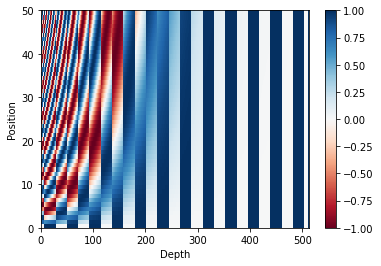

In [15]:
#Визуализируем вектора поцизионного кодирования
# Зададим значения 50, 512
pos_encoding = positional_encoding(50, 512)
print(pos_encoding.shape)

# Выведем значения поз. кодирования в виде heatmap
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

Пишем класс MultiHeadAttention. Писать слои attention своими руками не будем, используем готовый слой Attention из модуля keras (tf.keras.layers.Attention(use_scale=False, **kwargs))

Принимает на вход список из наших знакомых Query, Value, Key На выходе вектор внимания той же размерности.

In [16]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, 
               d_model = 512, # Размерность емб. пространства
               num_heads = 8, # Количество голов сети
               causal=False,  # Применять маску в Attention или нет
               dropout=0.0):  # Значение Dropout

    super(MultiHeadAttention, self).__init__()  # Здесь все головы считаем паралелльно - поэтому attention пробегает и по батчу и по числу голов

    assert d_model % num_heads == 0 # Проверим, что размерность головы - целое цисло
    depth = d_model // num_heads    # Размерность каждой головы внимания  =>>  multi-headed_depth = depth / num_heads
                                    # Заметим, что выходы голов конкатенируются, поэтому их размер в их число раз меньше.
                                    # Поэтому размерность выхода должно совпасть в размерностью входа

    self.w_query = tf.keras.layers.Dense(d_model)                            # Dense для Query  (batch_size , seq_length, depth) 
    self.split_reshape_query = tf.keras.layers.Reshape((-1,num_heads,depth)) # Слой для решейпа query до (batch_size , seq_length, num_heads, multi_headed_depth)  
    self.split_permute_query = tf.keras.layers.Permute((2,1,3))              # Слой для перестановки размерностей для использования Attention

    self.w_value = tf.keras.layers.Dense(d_model)                            # Dense для Value  (batch_size , seq_length, depth)
    self.split_reshape_value = tf.keras.layers.Reshape((-1,num_heads,depth)) # Слой для решейпа value до (batch_size , seq_length, num_heads, multi_headed_depth
    self.split_permute_value = tf.keras.layers.Permute((2,1,3))              # Слой для перестановки размерностей для использования Attention

    self.w_key = tf.keras.layers.Dense(d_model)                              # Dense для Key  (batch_size , seq_length, depth)
    self.split_reshape_key = tf.keras.layers.Reshape((-1,num_heads,depth))   # Слой для решейпа key до (batch_size , seq_length, num_heads, multi_headed_depth
    self.split_permute_key = tf.keras.layers.Permute((2,1,3))                # Слой для перестановки размерностей для использования Attention

    self.attention = tf.keras.layers.Attention(causal=causal, dropout=dropout) # Прописываем слой Attention
    self.join_permute_attention = tf.keras.layers.Permute((2,1,3))             # Слой обратной перестановки размерностей
    self.join_reshape_attention = tf.keras.layers.Reshape((-1,d_model))        # Слой обратного решейпа до размернсти модели

    self.dense = tf.keras.layers.Dense(d_model)     # Полносвязный слой

  def call(self, inputs, mask=None, training=None): # Основная рабочая функция

    q = inputs[0]                           # Вытащим входной вектор Query
    v = inputs[1]                           # Вытащим входной вектор Value
    k = inputs[2] if len(inputs) > 2 else v # Вытащим входной вектор Key

    query = self.w_query(q)                   # Прогоним через dense
    query = self.split_reshape_query(query)   # Решейпим
    query = self.split_permute_query(query)   # Переставляем размерность

    value = self.w_value(v)                 # Прогоним через dense
    value = self.split_reshape_value(value) # Решейпим
    value = self.split_permute_value(value) # Переставляем размерность

    key = self.w_key(k)               # Прогоним через dense
    key = self.split_reshape_key(key) # Решейпим
    key = self.split_permute_key(key) # Переставляем размерность

    if mask is not None: # Применим маску если есть 

      if mask[0] is not None:
        mask[0] = tf.keras.layers.Reshape((-1,1))(mask[0])     # Слой для решейпа
        mask[0] = tf.keras.layers.Permute((2,1))(mask[0])      # Слой для перестановки размерностей
      
      if mask[1] is not None:
        mask[1] = tf.keras.layers.Reshape((-1,1))(mask[1])     # Слой для решейпа
        mask[1] = tf.keras.layers.Permute((2,1))(mask[1])      # Слой для перестановки размерностей

    attention = self.attention([query, value, key], mask=mask) # Вычисляем вектор внимания
    attention = self.join_permute_attention(attention)         # Обратно перемешиваем размерности
    attention = self.join_reshape_attention(attention)         # Решейпим до (batch_size , seq_length, depth) 

    x = self.dense(attention) # Выходной dense

    return x

In [17]:
# Определим класс кодера. Он содержит один слой "многоголовое внимание", дропаут, слой сложения - создает resudial связь, слой нормализации и Feed Forward блок - в dense слоя.
class EncoderLayer(tf.keras.layers.Layer): 

  def __init__(self,  
               d_model = 512,  # Размерность емб. пространства
               num_heads = 8,  # Количество голов сети
               dff = 2048,     # Количество нейронов первого Dense слоя
               dropout = 0.0): # Значение Dropout
    
    super(EncoderLayer, self).__init__()

    self.multi_head_attention = MultiHeadAttention(d_model, num_heads)   # Определим слой  MultiHeadAttention
    self.dropout_attention = tf.keras.layers.Dropout(dropout)            # Добавим дропаут
    self.add_attention = tf.keras.layers.Add()                           # Слой для получения resudial связи
    self.layer_norm_attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)  # Слой нормализации

    self.dense1 = tf.keras.layers.Dense(dff, activation='relu')               # Первый dense в Feed Forward
    self.dense2 = tf.keras.layers.Dense(d_model)                              # Второй  dense в Feed Forward
    self.dropout_dense = tf.keras.layers.Dropout(dropout)                     # Добавим дропаут
    self.add_dense = tf.keras.layers.Add()                                    # Слой для получения resudial связи
    self.layer_norm_dense = tf.keras.layers.LayerNormalization(epsilon=1e-6)  # Слой нормализации

  def call(self, inputs, mask=None, training=None):

    # Входной вектор input размножим до 3 - это query, value, key и отдадим attenton, с маской если есть 
    attention = self.multi_head_attention([inputs,inputs,inputs], mask = [mask,mask]) 
    
    # Уменьшим переобучение дроаутом
    attention = self.dropout_attention(attention, training = training) 
    
    # Сделаем resudial связь - добавим входной вектор
    x = self.add_attention([inputs , attention]) 
    
    # Далее нормализация в масштабах уровня
    x = self.layer_norm_attention(x)  

    # Добавим Feed Forward  
    # Проходим 1й dense с активашкой relu
    dense = self.dense1(x) 
    
    # Второй dense без активашки т.е. с линейной активационной функцией
    dense = self.dense2(dense)  
    
    # Добавляем дропаут
    dense = self.dropout_dense(dense, training = training)  
    
    # Еще одна resudial связь
    x = self.add_dense([x , dense])  
    
    # Нормализация в масштабах уровня
    x = self.layer_norm_dense(x)  

    return x

In [18]:
# Определим класс слой декодера, который содержит один слой "многоголовое внимание", дропаут, слой сложения - создает resudial связь, слой нормализации и Feed Forward блок - в dense слоя:
class DecoderLayer(tf.keras.layers.Layer):

  def __init__(self,  
               d_model = 512,  # Размерность емб. пространства
               num_heads = 8,  # Количество голов сети
               dff = 2048,     # Количество нейронов первого Dense слоя
               dropout = 0.0): # Значение Dropout

    super(DecoderLayer, self).__init__()

    self.multi_head_attention1 =  MultiHeadAttention(d_model, num_heads, causal = True) # Определим слой  MultiHeadAttention
    self.dropout_attention1 = tf.keras.layers.Dropout(dropout)                          # Добавим дропаут
    self.add_attention1 = tf.keras.layers.Add()                                         # Слой для получения resudial связи
    self.layer_norm_attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)       # Слой нормализации

    self.multi_head_attention2 =  MultiHeadAttention(d_model, num_heads)                # Определим слой  MultiHeadAttention 
    self.dropout_attention2 = tf.keras.layers.Dropout(dropout)                          # Добавим дропаут
    self.add_attention2 = tf.keras.layers.Add()                                         # Слой для получения resudial связи
    self.layer_norm_attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)       # Слой нормализации


    self.dense1 = tf.keras.layers.Dense(dff, activation='relu')                         # Первый dense в Feed Forward
    self.dense2 = tf.keras.layers.Dense(d_model)                                        # Второй  dense в Feed Forward
    self.dropout_dense = tf.keras.layers.Dropout(dropout)                               # Добавим дропаут
    self.add_dense = tf.keras.layers.Add()                                              # Слой для получения resudial связи
    self.layer_norm_dense = tf.keras.layers.LayerNormalization(epsilon=1e-6)            # Слой нормализации

  def call(self, inputs, mask=None, training=None):
    
    # Подадим на multi-head attention  Query, Key, Value вектора - здесь это один и тот же вектор
    attention = self.multi_head_attention1([inputs[0],inputs[0],inputs[0]], mask = [mask[0],mask[0]])
    
    # Пробежим дропаут
    attention = self.dropout_attention1(attention, training = training)
    
    # Пробросим Resudial-связь
    x = self.add_attention1([inputs[0] , attention])
    
    # Выполним нормализацию
    x = self.layer_norm_attention1(x)
    
    # Второй multi-head attention. Подаем выход предыдущих слоев x и выход от энкодера, маску (если есть)
    attention = self.multi_head_attention2([x, inputs[1],inputs[1]], mask = [mask[0],mask[1]])
    
    # Прогоняем через дропаут
    attention = self.dropout_attention2(attention, training = training)
    
    # Пробросим Resudial-связь
    x = self.add_attention1([x , attention])
    
    # Выполним нормализацию
    x = self.layer_norm_attention1(x)

    # Feed Forward
    # 1 dense + relu
    dense = self.dense1(x)

    # 2 dense +linear
    dense = self.dense2(dense)

    # Прогоняем через дропаут
    dense = self.dropout_dense(dense, training = training)

    # Пробросим Resudial-связь
    x = self.add_dense([x , dense])

    # Выполним нормализацию
    x = self.layer_norm_dense(x)

    return x

In [19]:
# Создаем сам кодер из слоев, описанных ранее (embedding, позиционное кодирование, пачки кодеров):
class Encoder(tf.keras.layers.Layer):

  def __init__(self, 
               input_vocab_size,                  # Размер словаря
               num_layers = 4,                    # Количество слоев энкодера
               d_model = 512,                     # Размерность емб. пространства
               num_heads = 8,                     # Количество голов сети
               dff = 2048,                        # Количество нейронов первого Dense слоя
               maximum_position_encoding = 10000, # Максимальное число позиций
               dropout = 0.0):                    # Значение Dropout
    
    super(Encoder, self).__init__()

    self.d_model = d_model

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, # Пропишем слой Embedding
                                               d_model, 
                                               mask_zero=True)  
    
    self.pos = positional_encoding(maximum_position_encoding,    # Функция позиционного кодирования
                                   d_model)   
                   
    self.encoder_layers = [ EncoderLayer(d_model = d_model,      # Список Nx слоев кодера
                                         num_heads = num_heads, 
                                         dff = dff, 
                                         dropout = dropout) for _ in range(num_layers)]  

    self.dropout = tf.keras.layers.Dropout(dropout)              # Просто дропаут

  def call(self, inputs, mask=None, training=None):
    
    # Входной эмбеддинг  
    x = self.embedding(inputs) 
    
    # Позиционное кодирование
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32)) 
    x += self.pos[: , :tf.shape(x)[1], :]
    
    # Прогоняем через дропаут
    x = self.dropout(x, training=training)

    # Входной слой embedding+ Позиционное кодирование
    embedding_mask = self.embedding.compute_mask(inputs)

    # Прогоним через Nx слоев кодера
    for encoder_layer in self.encoder_layers: 
      x = encoder_layer(x, mask = embedding_mask)

    return x

  # Закомментируйте код ниже, если хотите использовать masked_loss()
  def compute_mask(self, inputs, mask=None):
    return self.embedding.compute_mask(inputs)

In [20]:
#Создаем сам декодер из слоев, описанных выше (embedding, позиционное кодирование, пачки декодеров):
class Decoder(tf.keras.layers.Layer):

  def __init__(self, 
               target_vocab_size,                 # Размер словаря выходных данных
               num_layers = 4,                    # Количество слоев декодера
               d_model = 512,                     # Размерность емб. пространства
               num_heads = 8,                     # Количество голов сети
               dff = 2048,                        # Количество нейронов первого Dense слоя
               maximum_position_encoding = 10000, # Максимальное число позиций
               dropout = 0.0):                    # Значение Dropout
    
    super(Decoder, self).__init__()

    self.d_model = d_model

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, # Пропишем слой Embedding
                                               d_model, 
                                               mask_zero=True) 
    
    self.pos = positional_encoding(maximum_position_encoding,     # Функция позиционного кодирования
                                   d_model)                     

    self.decoder_layers = [ DecoderLayer(d_model = d_model, 
                                         num_heads = num_heads, 
                                         dff = dff, 
                                         dropout = dropout)  for _ in range(num_layers)] # Список Nx слоев декодера 

    self.dropout = tf.keras.layers.Dropout(dropout)               # Слой дропаут

  def call(self, inputs, mask=None, training=None):
    
    # Выполним переход в эмбеддинг
    x = self.embedding(inputs[0]) 
    
    # Позиционное кодирование
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos[: , :tf.shape(x)[1], :]
    
    # Просто dropout
    x = self.dropout(x, training=training)
    
    # Входной слой embedding + Позиционное кодирование
    embedding_mask = self.embedding.compute_mask(inputs[0])

    # Прогоним через Nx слоев декодера
    for decoder_layer in self.decoder_layers:
      x = decoder_layer([x,inputs[1]], mask = [embedding_mask, mask])

    return x

  # Закомментируйте код ниже, если хотите использовать masked_loss()
  def compute_mask(self, inputs, mask=None):
    return self.embedding.compute_mask(inputs[0])

In [ ]:
#Соберем модель: 2 входных слоя, кодер, декодер, выходной dense:
num_layers = 4 # Количество слоев
d_model = 128  # Размерность емб. пространства
dff = 512      # Количество нейронов первого Dense слоя
num_heads = 8  # Количество голов

dropout_rate = 0.1 # Значение Dropout

input_vocab_size = tokenizer_ru.vocab_size + 2  # Индекс входного тега
target_vocab_size = tokenizer_en.vocab_size + 2 # Индекс выходного тега


input  = tf.keras.layers.Input(shape=(None,)) # Входной слой для переводимой фразы
target = tf.keras.layers.Input(shape=(None,)) # Вход для перевода

encoder = Encoder(input_vocab_size,           # Создаем энкодер
                  num_layers = num_layers, 
                  d_model = d_model, 
                  num_heads = num_heads, 
                  dff = dff, 
                  dropout = dropout_rate)  

decoder = Decoder(target_vocab_size,          # Создаем декодер
                  num_layers = num_layers, 
                  d_model = d_model, 
                  num_heads = num_heads, 
                  dff = dff, 
                  dropout = dropout_rate) 

# Собираем модель 
x = encoder(input)
x = decoder([target, x] , mask = encoder.compute_mask(input))
x = tf.keras.layers.Dense(target_vocab_size)(x)

# Формируем модель, выводим саммери
model = tf.keras.models.Model(inputs=[input, target], outputs=x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 encoder (Encoder)              (None, None, 128)    1840256     ['input_1[0][0]']                
                                                                                                  
 tf.math.not_equal (TFOpLambda)  (None, None)        0           ['input_1[0][0]']                
                                                                                              

(64, 40, 8247)

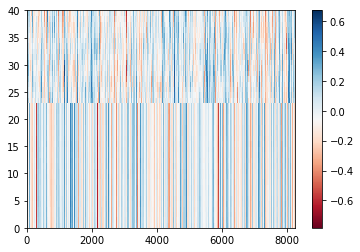

In [ ]:
#Проверим работоспособность:
# Возьмем пример данн
ru_batch, en_batch = next(iter(val_dataset))

# Выведем результат предсказания в виде тепловой карты
plt.pcolormesh(model.predict([ru_batch,en_batch])[5],cmap='RdBu')
plt.colorbar()

# Размерность предикта
model.predict([ru_batch,en_batch]).shape

In [21]:
#Класс CustomSchedule предназначен для создания собственных параметров оптимизатора.
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [25]:
#Задаем оптимайзер, функцию потерь, метрики и компилируем модель
# Оптимайзер 
optimizer = tf.keras.optimizers.Adam(CustomSchedule(d_model), 
                                     beta_1=0.9, 
                                     beta_2=0.98, 
                                     epsilon=1e-9)
# Функция потерь
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

# Мы рассчитываем потери, используя предопределенную целевую функцию, 
# а затем дополняем ее маской.

def masked_loss(y_true, y_pred):

  # Считаем маску  
  mask = tf.math.logical_not(tf.math.equal(y_true, 0))
  _loss = loss(y_true, y_pred)

  mask = tf.cast(mask, dtype=_loss.dtype)

  # Накинем маску на потери  
  _loss *= mask

  return tf.reduce_sum(_loss)/tf.reduce_sum(mask)

metrics = [loss, masked_loss, tf.keras.metrics.SparseCategoricalAccuracy()]

model2.compile(optimizer=optimizer, loss = loss, metrics = metrics) # masked_

In [30]:
#Проверим число батчей для обучения и проверки:
# Количество батчей для обучения
num_batches = 0
for (batch, (_,_)) in enumerate(train_dataset):
  num_batches = batch
print(num_batches)

# Количество батчей для проверки
val_batches = 0
for (batch, (_,_)) in enumerate(val_dataset):
  val_batches = batch
print(val_batches)

2624
60


In [28]:
#Напишем генератор. По номеру будем получать батч данных для обучения, запустим обучение:

#Функция generator() принимает на вход данные и посредством генератора (конструкции while_yeld) получает из данных по батчу на каждой итерации, при этом не заполняя память.
def generator(data_set):
    
  while True:
    for ru_batch, en_batch in data_set:
      yield ( [ru_batch , en_batch[:, :-1] ] , en_batch[:, 1:] )

# При помощи генератора запускаем обучение
history = model.fit(x = generator(train_dataset),              # Данные для обучения
                    validation_data = generator(val_dataset),  # Данные для проверки
                    epochs=2,                                  # Количество эпох
                    steps_per_epoch = num_batches,             # Количество батчей
                    validation_steps = val_batches)            # Батчи на проверку

NameError: ignored

In [ ]:
# На кодер подаем исходную фразу, токен start на декодер - предиктим первое слово. Выход декодера подаем на его вход и предиктим второе слово. 
#Второе слово дописываем к первому, и подаем на вход декодера. Процедура останавливается, как только токен stop получен. Переведенная фраза без токенов start/stop декодируется в текст.

#Проверим качество перевода. Выведем вместе предсказанный перевод и эталонную фразу
# Возьмем первые 10 значений данных
for i in range(10):
  translation = [tokenizer_en.vocab_size]

  # Пройдём по каждому токену (максимум 40)
  for _ in range(40):
    predict = model.predict([ru_batch[i:i+1],np.asarray([translation])]) # Делаем предикт
    translation.append(np.argmax(predict[-1,-1]))                        # Ищем индекс токена
    if translation[-1] == tokenizer_en.vocab_size + 1:                   # Если предсказан выходной тег, то заканчиваем цикл
      break
  
  # Переводим фразу из индексов в слова и выводим на экран
  real_translation = []
  for w in en_batch[:,1:][i].numpy():
    if w == tokenizer_en.vocab_size + 1:
      break
    real_translation.append(w)
  print('Реальный перевод:     ', tokenizer_en.decode(real_translation))
  print('Перевод трансформером:', tokenizer_en.decode(translation[1:-1]))
  print("")

Реальный перевод:      ( laughter ) they are the toughest opponents .
Перевод трансформером: ( laughter ) they have a very good thing .

Реальный перевод:      had they had their fuel supplies , they would have done it .
Перевод трансформером: and if they could be able to be able to be able to be able to do it .

Реальный перевод:      ( applause )
Перевод трансформером: ( applause )

Реальный перевод:      the first thing you have to consider is that there are parts of the world that are dark spots in terms of attention .
Перевод трансформером: the first thing that is that it should be to do is that it is that the world is the most important thing in the world .

Реальный перевод:      and so we started talking about this .
Перевод трансформером: and these things are all of these things .

Реальный перевод:      and everything that i had been taught regarding sound , i decided to do away with and unlearn .
Перевод трансформером: i decided to do that to be able to be a very good thing 

Модель обучилась плохо. Переводит невпопад. Дообучим еще на паре эпох - посмотрим, как это повлияет на результаты.

In [29]:
history = model.fit(x = generator(train_dataset),              # Данные для обучения
                    validation_data = generator(val_dataset),  # Данные для проверки
                    epochs=2,                                  # Количество эпох
                    steps_per_epoch = num_batches,             # Количество батчей
                    validation_steps = val_batches)            # Батчи на проверку

Epoch 1/2
2624/2624 [==============================] - 413s 157ms/step - loss: 1.7815 - sparse_categorical_crossentropy: 3.3930 - masked_loss: 3.5708 - sparse_categorical_accuracy: 0.4238 - val_loss: 1.5750 - val_sparse_categorical_crossentropy: 3.0745 - val_masked_loss: 3.2419 - val_sparse_categorical_accuracy: 0.4661
Epoch 2/2
2624/2624 [==============================] - 420s 160ms/step - loss: 1.6138 - sparse_categorical_crossentropy: 3.0713 - masked_loss: 3.2322 - sparse_categorical_accuracy: 0.4582 - val_loss: 1.4546 - val_sparse_categorical_crossentropy: 2.8396 - val_masked_loss: 2.9941 - val_sparse_categorical_accuracy: 0.4937


In [30]:
# посмотрим, насколько удалось улучшить модель путем дообучения:
for i in range(5):
  translation = [tokenizer_en.vocab_size]

  # Пройдём по каждому токену (максимум 40)
  for _ in range(40):
    predict = model.predict([ru_batch[i:i+1],np.asarray([translation])]) # Делаем предикт
    translation.append(np.argmax(predict[-1,-1]))                        # Ищем индекс токена
    if translation[-1] == tokenizer_en.vocab_size + 1:                   # Если предсказан выходной тег, то заканчиваем цикл
      break
  
  # Переводим фразу из индексов в слова и выводим на экран
  real_translation = []
  for w in en_batch[:,1:][i].numpy():
    if w == tokenizer_en.vocab_size + 1:
      break
    real_translation.append(w)
  print('Реальный перевод:     ', tokenizer_en.decode(real_translation))
  print('Перевод трансформером:', tokenizer_en.decode(translation[1:-1]))
  print("")

Реальный перевод:      ( laughter ) they are the toughest opponents .
Перевод трансформером: ( laughter ) they are a very low time .

Реальный перевод:      had they had their fuel supplies , they would have done it .
Перевод трансформером: and if they had access to them , they would do that .

Реальный перевод:      ( applause )
Перевод трансформером: ( applause )

Реальный перевод:      the first thing you have to consider is that there are parts of the world that are dark spots in terms of attention .
Перевод трансформером: the first thing that you have to do is that it 's a place in the world , which is the world , which is the largest dot is the dark .

Реальный перевод:      and so we started talking about this .
Перевод трансформером: and since these conversations were all started to start with them .



Уже интереснее. Модель стала предсказывать лучше. Дообучим еще на 5 эпохах

In [31]:
history = model.fit(x = generator(train_dataset),              # Данные для обучения
                    validation_data = generator(val_dataset),  # Данные для проверки
                    epochs=5,                                  # Количество эпох
                    steps_per_epoch = num_batches,             # Количество батчей
                    validation_steps = val_batches)            # Батчи на проверку

Epoch 1/5
2624/2624 [==============================] - 414s 158ms/step - loss: 1.5019 - sparse_categorical_crossentropy: 2.8606 - masked_loss: 3.0104 - sparse_categorical_accuracy: 0.4818 - val_loss: 1.3855 - val_sparse_categorical_crossentropy: 2.7047 - val_masked_loss: 2.8519 - val_sparse_categorical_accuracy: 0.5093
Epoch 2/5
2624/2624 [==============================] - 411s 157ms/step - loss: 1.4279 - sparse_categorical_crossentropy: 2.7198 - masked_loss: 2.8622 - sparse_categorical_accuracy: 0.4982 - val_loss: 1.3340 - val_sparse_categorical_crossentropy: 2.6042 - val_masked_loss: 2.7459 - val_sparse_categorical_accuracy: 0.5218
Epoch 3/5
2624/2624 [==============================] - 409s 156ms/step - loss: 1.3732 - sparse_categorical_crossentropy: 2.6148 - masked_loss: 2.7518 - sparse_categorical_accuracy: 0.5108 - val_loss: 1.3004 - val_sparse_categorical_crossentropy: 2.5386 - val_masked_loss: 2.6767 - val_sparse_categorical_accuracy: 0.5301
Epoch 4/5
2624/2624 [================

In [32]:
# посмотрим, насколько удалось улучшить модель путем очередного дообучения:
for i in range(5):
  translation = [tokenizer_en.vocab_size]

  # Пройдём по каждому токену (максимум 40)
  for _ in range(40):
    predict = model.predict([ru_batch[i:i+1],np.asarray([translation])]) # Делаем предикт
    translation.append(np.argmax(predict[-1,-1]))                        # Ищем индекс токена
    if translation[-1] == tokenizer_en.vocab_size + 1:                   # Если предсказан выходной тег, то заканчиваем цикл
      break
  
  # Переводим фразу из индексов в слова и выводим на экран
  real_translation = []
  for w in en_batch[:,1:][i].numpy():
    if w == tokenizer_en.vocab_size + 1:
      break
    real_translation.append(w)
  print('Реальный перевод:     ', tokenizer_en.decode(real_translation))
  print('Перевод трансформером:', tokenizer_en.decode(translation[1:-1]))
  print("")

Реальный перевод:      ( laughter ) they are the toughest opponents .
Перевод трансформером: ( laughter ) they 're strongly generous .

Реальный перевод:      had they had their fuel supplies , they would have done it .
Перевод трансформером: and if they had access to the fuel of them — they would do that .

Реальный перевод:      ( applause )
Перевод трансформером: ( applause )

Реальный перевод:      the first thing you have to consider is that there are parts of the world that are dark spots in terms of attention .
Перевод трансформером: the first thing that should be done is that there are parts of the world that are dark in the world .

Реальный перевод:      and so we started talking about this .
Перевод трансформером: and since these conversations started this .



Получилось еще повысить точность. Фразы, предсказываемые моделью, стали ближе к правильному ответу, в них уже присутствует логика, меньше повторяемых несколько раз подряд грамматических форм. 

Попробуем усложнить саму модель: добавим слоев. Обучим на 10 эпохах и посмотрим на результат

In [23]:
#Соберем модель: 2 входных слоя, кодер, декодер, выходной dense:
num_layers = 8 # Количество слоев
d_model = 128  # Размерность емб. пространства
dff = 512      # Количество нейронов первого Dense слоя
num_heads = 8  # Количество голов

dropout_rate = 0.1 # Значение Dropout

input_vocab_size = tokenizer_ru.vocab_size + 2  # Индекс входного тега
target_vocab_size = tokenizer_en.vocab_size + 2 # Индекс выходного тега


input  = tf.keras.layers.Input(shape=(None,)) # Входной слой для переводимой фразы
target = tf.keras.layers.Input(shape=(None,)) # Вход для перевода

encoder2 = Encoder(input_vocab_size,           # Создаем энкодер
                  num_layers = num_layers, 
                  d_model = d_model, 
                  num_heads = num_heads, 
                  dff = dff, 
                  dropout = dropout_rate)  

decoder2 = Decoder(target_vocab_size,          # Создаем декодер
                  num_layers = num_layers, 
                  d_model = d_model, 
                  num_heads = num_heads, 
                  dff = dff, 
                  dropout = dropout_rate) 

# Собираем модель 
x = encoder2(input)
x = decoder2([target, x] , mask = encoder2.compute_mask(input))
x = tf.keras.layers.Dense(target_vocab_size)(x)

# Формируем модель, выводим саммери
model2 = tf.keras.models.Model(inputs=[input, target], outputs=x)
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 encoder (Encoder)              (None, None, 128)    2633344     ['input_1[0][0]']                
                                                                                                  
 tf.math.not_equal (TFOpLambda)  (None, None)        0           ['input_1[0][0]']                
                                                                                              

In [26]:
model2.compile(optimizer=optimizer, loss = loss, metrics = metrics) # masked_

In [31]:
def generator(data_set):
    
  while True:
    for ru_batch, en_batch in data_set:
      yield ( [ru_batch , en_batch[:, :-1] ] , en_batch[:, 1:] )


# При помощи генератора запускаем обучение
history = model2.fit(x = generator(train_dataset),              # Данные для обучения
                    validation_data = generator(val_dataset),  # Данные для проверки
                    epochs=10,                                  # Количество эпох
                    steps_per_epoch = num_batches,             # Количество батчей
                    validation_steps = val_batches)            # Батчи на проверку

Epoch 1/10
2624/2624 [==============================] - 770s 279ms/step - loss: 2.8877 - sparse_categorical_crossentropy: 5.5009 - masked_loss: 5.7273 - sparse_categorical_accuracy: 0.2198 - val_loss: 2.2679 - val_sparse_categorical_crossentropy: 4.4272 - val_masked_loss: 4.6678 - val_sparse_categorical_accuracy: 0.3072
Epoch 2/10
2624/2624 [==============================] - 721s 275ms/step - loss: 2.2955 - sparse_categorical_crossentropy: 4.3695 - masked_loss: 4.5982 - sparse_categorical_accuracy: 0.3143 - val_loss: 2.1290 - val_sparse_categorical_crossentropy: 4.1561 - val_masked_loss: 4.3824 - val_sparse_categorical_accuracy: 0.3337
Epoch 3/10
2624/2624 [==============================] - 724s 276ms/step - loss: 2.1880 - sparse_categorical_crossentropy: 4.1640 - masked_loss: 4.3821 - sparse_categorical_accuracy: 0.3307 - val_loss: 2.0709 - val_sparse_categorical_crossentropy: 4.0427 - val_masked_loss: 4.2628 - val_sparse_categorical_accuracy: 0.3400
Epoch 4/10
2624/2624 [============

In [33]:
# посмотрим, насколько удалось улучшить модель путем очередного дообучения:
for i in range(5):
  translation = [tokenizer_en.vocab_size]

  # Пройдём по каждому токену (максимум 40)
  for _ in range(40):
    predict = model2.predict([ru_batch[i:i+1],np.asarray([translation])]) # Делаем предикт
    translation.append(np.argmax(predict[-1,-1]))                        # Ищем индекс токена
    if translation[-1] == tokenizer_en.vocab_size + 1:                   # Если предсказан выходной тег, то заканчиваем цикл
      break
  
  # Переводим фразу из индексов в слова и выводим на экран
  real_translation = []
  for w in en_batch[:,1:][i].numpy():
    if w == tokenizer_en.vocab_size + 1:
      break
    real_translation.append(w)
  print('Реальный перевод:     ', tokenizer_en.decode(real_translation))
  print('Перевод трансформером:', tokenizer_en.decode(translation[1:-1]))
  print("")

Реальный перевод:      ( laughter ) they are the toughest opponents .
Перевод трансформером: ( laughter ) it 's a very different thing .

Реальный перевод:      had they had their fuel supplies , they would have done it .
Перевод трансформером: and you can see the same thing that you can see in the middle of the world .

Реальный перевод:      ( applause )
Перевод трансформером: ( applause )

Реальный перевод:      the first thing you have to consider is that there are parts of the world that are dark spots in terms of attention .
Перевод трансформером: and the first thing that we have is that the world is the most important to be able to do with the same thing .

Реальный перевод:      and so we started talking about this .
Перевод трансформером: and this is the first time in the world .



К сожалению, конкретно этот эксперимент не улучшил модель. 

## Выводы

В этом задании перед нами стояла задача, взяв за основу практический ноутбук занятия, восстановить архитектуру трансформера и обучить модель для перевода русского текста на английский. Для этого использовать базу ted_hrlr_translate/ru_to_en из tfds.

Добиться более-менее адекватного перевода текста.

На мой взгляд, задачи удалось достичь. Обучив модель на 9 эпохах с  4 слоями, с размерностью емб. пространства  = 128, количеством нейронов первого Dense слоя = 512 и количеством голов = 8 - мы получили вполне адекватный перевод текста. 
Возможно, имело бы смысл попробовать изменить параметры модели с целью дальнейшего уменьшения. В рамках данной работы проведен эксперимент по увеличению количества слоев, однако, к сожалению, это точность не увеличило, а, наоборот, уменьшило.

Пространством для дальнейших экспериментов могла бы стать проверка определенных гипотез и их влияния на эффективность модели - увеличения голов SelfAttention, измениния размерности эмбеддинг пространства, а также количества нейронов в различных слоях кодера-декодера.